In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, max_error
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import skopt,scipy
import pickle

In [3]:
df = pd.read_csv('../data/train_data.csv', on_bad_lines='skip')

In [4]:
rf1 = pickle.load(open('rf1.sav', 'rb'))
rf2 = pickle.load(open('rf2.sav', 'rb'))

In [5]:
train, test = train_test_split(df, train_size=0.7, random_state=42, shuffle=True)

In [6]:
def delete_column_rows(df, val):
    df = df.drop(['BBLE','OWNER','BLOCK','LOT','BORO','STADDR','POSTCODE','AVLAND2','AVTOT2','EXLAND2','EXTOT2','EXCD2','PERIOD','VALTYPE','Community Board','Census Tract','BIN','NTA','New Georeferenced Column','Council District'], axis = 1)
    val = val.drop(['BBLE','OWNER','BLOCK','LOT','BORO','STADDR','POSTCODE','AVLAND2','AVTOT2','EXLAND2','EXTOT2','EXCD2','PERIOD','VALTYPE','Community Board','Census Tract','BIN','NTA','New Georeferenced Column','Council District'], axis = 1)
    df.loc[((df['LTFRONT'] * df['LTDEPTH']) == 0) & ((df['BLDFRONT'] * df['BLDDEPTH']) == 0),['LTFRONT','LTDEPTH','BLDDEPTH','BLDFRONT']] = np.nan
    val.loc[((val['LTFRONT'] * val['LTDEPTH']) == 0) & ((val['BLDFRONT'] * val['BLDDEPTH']) == 0),['LTFRONT','LTDEPTH','BLDDEPTH','BLDFRONT']] = np.nan
    df['BLDGCL'] = np.where(df['BLDGCL'].isin({'A5', 'R3', 'B2', 'A1', 'C0', 'B9', 'A2', 'B1', 'A9', 'A0', 'C1', 'B3', 'V0', 'R1', 'C7', 'R2'}),
                           df['BLDGCL'], 'Other')
    val['BLDGCL'] = np.where(val['BLDGCL'].isin({'A5', 'R3', 'B2', 'A1', 'C0', 'B9', 'A2', 'B1', 'A9', 'A0', 'C1', 'B3', 'V0', 'R1', 'C7', 'R2'}),
                           val['BLDGCL'], 'Other')
    df['YEAR'] = df['YEAR'].apply(lambda x: x[0:4])
    val['YEAR'] = val['YEAR'].apply(lambda x: x[0:4])
    df['LOTAREA'] = df['LTFRONT'] * df['LTDEPTH']    
    df['BLDAREA'] = df['BLDFRONT'] * df['BLDDEPTH']
    df = df.drop(['LTFRONT','LTDEPTH','BLDFRONT','BLDDEPTH'],axis = 1)
    val['LOTAREA'] = val['LTFRONT'] * val['LTDEPTH']    
    val['BLDAREA'] = val['BLDFRONT'] * val['BLDDEPTH']
    val = val.drop(['LTFRONT','LTDEPTH','BLDFRONT','BLDDEPTH'],axis = 1)
    return df, val

In [7]:
def fit(X_train, X_test, y_train, y_test, rf1, rf2):
    ohe = OneHotEncoder()
    index = X_train.index
    drop = X_train.drop(['EASEMENT','EXT','EXMPTCL','YEAR','Borough','BLDGCL','TAXCLASS'], axis=1)
    X_train = ohe.fit_transform(X_train[['EASEMENT','EXT','EXMPTCL','YEAR','Borough','BLDGCL','TAXCLASS']]).toarray()
    col = ohe.get_feature_names_out(['EASEMENT','EXT','EXMPTCL','YEAR','Borough','BLDGCL','TAXCLASS'])
    X_train = pd.DataFrame(X_train, index = index, columns = col)
    X_train = X_train.join(drop)
    index = X_test.index
    drop = X_test.drop(['EASEMENT','EXT','EXMPTCL','YEAR','Borough','BLDGCL','TAXCLASS'], axis=1)
    X_test = ohe.transform(X_test[['EASEMENT','EXT','EXMPTCL','YEAR','Borough','BLDGCL','TAXCLASS']]).toarray()
    X_test = pd.DataFrame(X_test, index = index, columns = col)
    X_test = X_test.join(drop)
    
    imputer = KNNImputer(n_neighbors=1)
    imputer.fit(X_train)
    X_train = pd.DataFrame(imputer.transform(X_train.values), columns = X_train.columns, index = X_train.index)
    X_test = pd.DataFrame(imputer.transform(X_test.values), columns = X_test.columns, index = X_test.index)
    X_train = X_train.drop(['YEAR_2017','EASEMENT_nan','EXT_nan','EXMPTCL_nan','Borough_nan'], axis = 1)
    X_test = X_test.drop(['YEAR_2017','EASEMENT_nan','EXT_nan','EXMPTCL_nan','Borough_nan'], axis = 1)
    
    
    outliers = ['STORIES','LOTAREA','BLDAREA']
    for column in outliers:
        low = np.quantile(X_train[column], 0.025)
        high = np.quantile(X_train[column], 0.975)
        X_train.loc[X_train[column] < low, column] = low
        X_train.loc[X_train[column] > high, column] = high
        X_test.loc[X_test[column] < low, column] = low
        X_test.loc[X_test[column] > high, column] = high
    
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train.values), columns = X_train.columns, index = X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test.values), columns = X_test.columns, index = X_test.index)
    
    
    rf1.fit(X_train,y_train)
    q = np.quantile(rf1.feature_importances_, 0.5)
    weak_columns = rf1.feature_names_in_[np.where(rf1.feature_importances_ < q)]
    X_train.drop(weak_columns, axis=1, inplace=True)
    X_test.drop(weak_columns, axis=1, inplace=True)
    
    rf2.fit(X_train,y_train)
    importance = rf2.feature_importances_
    col_importance = pd.DataFrame({'col': X_train.columns, 'importance': importance}, columns=['col','importance'])
    corr_matrix = X_train.corr(method='pearson').abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = []
    j=1
    for column in upper.columns:
        if(j == upper.columns.size):
            break
        j+=1
        if any(upper[column]>0.8):
            correlated = upper[upper[column]>0.8].index
            most_important = column
            for col in correlated:
                if col_importance.loc[col_importance.col == col]['importance'].values[0] > col_importance.loc[col_importance.col == most_important]['importance'].values[0]:
                    to_drop.append(most_important)
                    most_important = col
                else:
                    to_drop.append(col)

    corr_matrix = X_train.corr(method='spearman').abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    j=1
    for column in upper.columns:
        if(j == upper.columns.size):
            break
        j+=1
        if any(upper[column]>0.8):
            correlated = upper[upper[column]>0.8].index
            most_important = column
            for col in correlated:
                if col_importance.loc[col_importance.col == col]['importance'].values[0] > col_importance.loc[col_importance.col == most_important]['importance'].values[0]:
                    to_drop.append(most_important)
                    most_important = col
                else:
                    to_drop.append(col)
    X_train.drop(to_drop, axis=1, inplace=True)
    X_test.drop(to_drop, axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

In [8]:
def pipe(train, test,rf1,rf2):
    train, test = delete_column_rows(train, test)
    y_train = train['FULLVAL']
    X_train = train.drop('FULLVAL', axis = 1)
    y_test = test['FULLVAL']
    X_test = test.drop('FULLVAL', axis = 1)
    X_train, X_test, y_train, y_test = fit(X_train, X_test, y_train, y_test,rf1,rf2)
    return X_train, X_test, y_train, y_test
    

In [9]:
X_train, X_test, y_train, y_test = pipe(train,test,rf1,rf2)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))
max_error(y_pred, y_test)

/home/bujak/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
/home/bujak/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
/home/bujak/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/bujak/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
<ipython-input-7-9694a54f71a1>:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` 

110071.57725018602


27109420.240000002

In [10]:
rf = RandomForestRegressor()

In [18]:
importances = pd.DataFrame(data = {"names" : X_train.columns, "vals" : model.feature_importances_}).sort_values(by = 'vals', ascending = True)

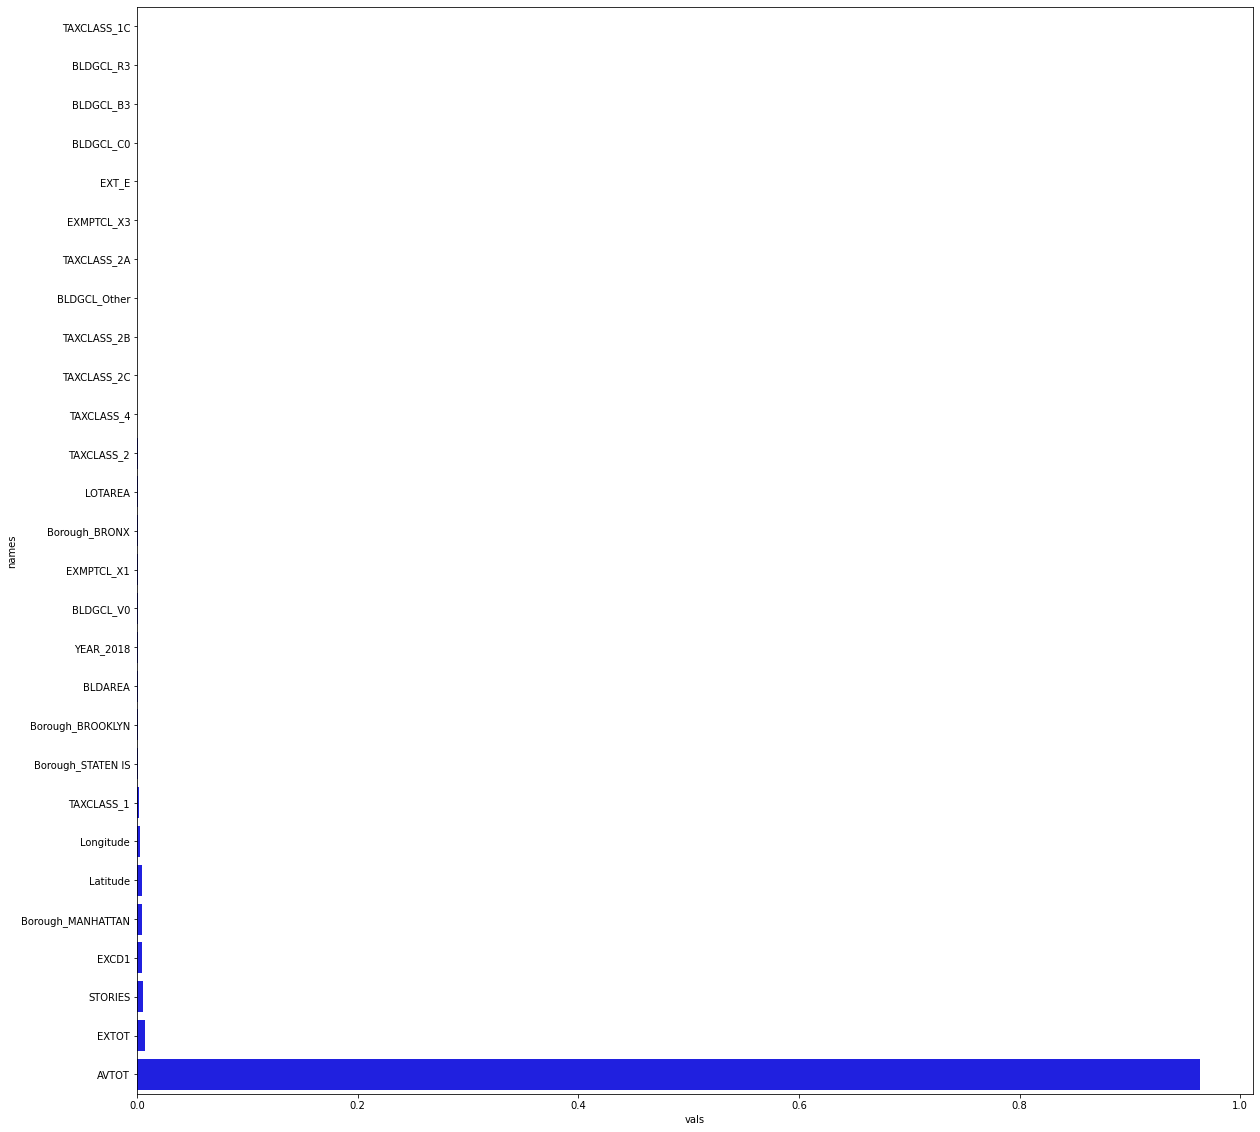

In [22]:
plt.figure(figsize=(20, 20))
sns.barplot(data = importances, x = "vals", y = "names", color = "blue")
plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
parameters = {
    'criterion': ['absolute_error'],
    'min_samples_leaf': scipy.stats.randint(2,20),
    'min_samples_split': scipy.stats.randint(3,20),
    'n_estimators': scipy.stats.randint(100,1500)
}

rs = RandomizedSearchCV(estimator = rf, param_distributions = parameters, verbose=10, 
                               cv = 3, n_iter = 50, n_jobs = -1, scoring='neg_mean_absolute_error')
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
rs.best_params_

In [ ]:
rs = rs.best_estimator_